dataset                                           object
id1                                               object
id2                                               object
isInStrictBlockingDecay                             bool
isInStrictBlockingNoDecay                           bool
isInValueSetBlocking                                bool
isInSequenceBlocking                                bool
isInExactMatchBlocking                              bool
isSemanticRoleMatch                                 bool
compatibilityPercentageDecay                     float64
compatibilityPercentageNoDecay                   float64
exactSequenceMatchPercentage                     float64
hasTransitionOverlapNoDecay                         bool
hasTransitionOverlapDecay                           bool
hasValueSetOverlap                                  bool
isInSVABlockingNoDecay                              bool
isInSVABlockingDecay                                bool
isInCBRB                       

/usr/local/lib/python3.8/dist-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 39'. Pick better value with 'binwidth'.


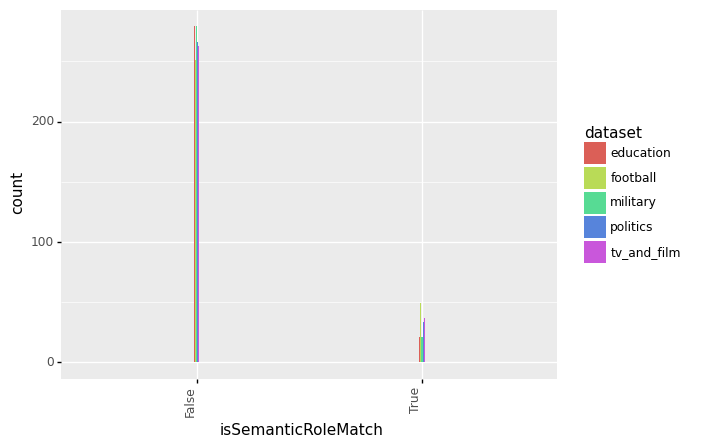

/usr/local/lib/python3.8/dist-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 16'. Pick better value with 'binwidth'.


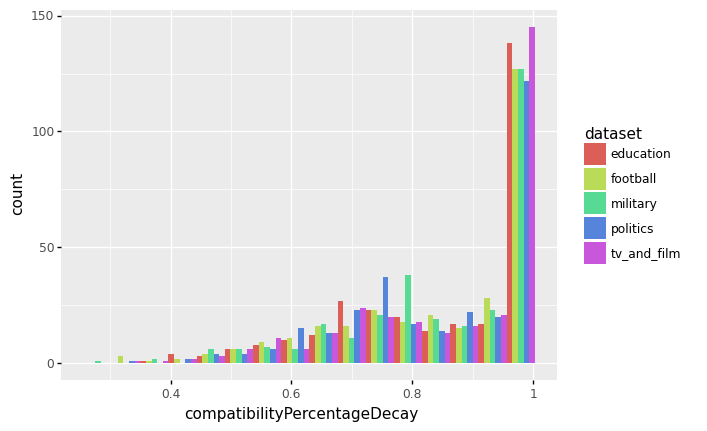

In [223]:
import pandas as pd
from plotnine import *
from plotnine.data import *
from tabulate import tabulate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_curve
import numpy as np

#df = pd.read_csv("localData/semanticAnnotation/results.csv")
df = pd.read_csv("localData/semanticAnnotation/results.csv")
df['isInCBRB'] = ((df['compatibilityPercentageDecay'] >=0.8))
df['isInCBRBNoDecay'] = ((df['compatibilityPercentageNoDecay'] >=0.8))
df['isInCBRBWithTransitionFilter'] = ((df['compatibilityPercentageDecay'] >=0.8) & df['hasTransitionOverlapDecay'])
df['isInCBRBNoDecayWithTransitionFilter'] = ((df['compatibilityPercentageNoDecay'] >=0.8) & df['hasTransitionOverlapNoDecay'])
df['isInStrictBlockingDecayWithTransitionFilter'] = ((df['compatibilityPercentageDecay'] >=1.0) & df['hasTransitionOverlapDecay'])
df['isInStrictBlockingNoDecayWithTransitionFilter'] = ((df['compatibilityPercentageNoDecay'] >=1.0) & df['hasTransitionOverlapNoDecay'])

#TODO about the filtering! Currently we are not applying the transition filters to CBRB and CBRB NoDecay but the table in the paper does - we need to choose what we want to represent in the final matrix

print(df.dtypes)

datasetToAbbreviation = {
'austintexas' : 'AU',
'chicago' : 'CH',
'gov.maryland' : 'MD',
'oregon' : 'OR',
'utah' : 'UT',
'education' : 'ED',
'football' : 'FO',
'military' : 'MI',
'politics' : 'PO',
'tv_and_film' : 'TV'
}

def getGroup(x):
    if(x==1.0):
        return "[1.0,1.0] (full)"
    elif(x >=0.7):
        return "[0.7,1.0) (70%)"
    else:
        return "[0.0,0.7) (<70%)"


df['groupDecay'] = df['compatibilityPercentageNoDecay'].map(lambda x: getGroup(x))
df['groupNoDecay'] = df['compatibilityPercentageNoDecay'].map(lambda x: getGroup(x))

#print(df.describe())
plot = ggplot(df,aes(x = 'isSemanticRoleMatch',fill="dataset",group='dataset')) + geom_histogram(position=position_dodge()) + theme(axis_text_x = element_text(angle=90, hjust=1))
print(plot)
plot = ggplot(df,aes(x = 'compatibilityPercentageDecay',fill="dataset")) + geom_histogram(position=position_dodge())
print(plot)

# for dsName in df.dataset.unique():
#     thisDF = df[df['dataset']==dsName]
#     print(dsName,"Positive Rate: ", sum(thisDF['isSemanticRoleMatch']) / len(thisDF.index) )
#     print(dsName,"Positive Counts/Rate in Compatible (with Decay): ",sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingDecay']), "/", sum(thisDF['isInStrictBlockingDecay']),sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingDecay']) / sum(thisDF['isInStrictBlockingDecay']) )
#
#     print(dsName,"Counts/Percentage of Semantic Being Compatible (with Decay): ",sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingDecay']),"/",sum(thisDF['isSemanticRoleMatch']), sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingDecay']) / sum(thisDF['isSemanticRoleMatch']) )
#     print(dsName,"Positive Counts/Rate in Compatible (without Decay): ",sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingNoDecay']),"/",sum(thisDF['isInStrictBlockingNoDecay']), sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingNoDecay']) / sum(thisDF['isInStrictBlockingNoDecay']) )
#     print(dsName,"Counts/Percentage of Semantic Being Compatible (without Decay): ",sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingNoDecay']),"/",sum(thisDF['isSemanticRoleMatch']), sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingNoDecay']) / sum(thisDF['isSemanticRoleMatch']) )

# Precision / Recall / F1

In [254]:
def getPRF(scoreName, group):
    tp = sum(((group[scoreName]) & (group['isSemanticRoleMatch'])))
    fp = sum(((group[scoreName]) & (~group['isSemanticRoleMatch'])))
    #tn = sum(((~group['isInCBRB']) & (~group['isSemanticRoleMatch'])))
    fn = sum((~group[scoreName] & group['isSemanticRoleMatch']))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1


def getFalsePositiveRateForScore(df, scoreName):
    dfWithMatches = df[df['isSemanticRoleMatch']]
    return str(round(1.0 - sum(dfWithMatches[scoreName]) / sum(df[scoreName]),2))

def getPrecisionForScore(df, scoreName):
    dfWithMatches = df[df['isSemanticRoleMatch']]
    return str(int(100*round(sum(dfWithMatches[scoreName]) / sum(df[scoreName]),2)))

def getRecallForScore(df, scoreName):
    dfWithMatches = df[df['isSemanticRoleMatch']]
    return str(int(100*round(sum(dfWithMatches[scoreName]) / len(dfWithMatches.index),2)))


def getF1ForScore(df, scoreName):
    precisionV1,recallV1,f1V1 = getPRF(scoreName,df)
    dfWithMatches = df[df['isSemanticRoleMatch']]
    precision = sum(dfWithMatches[scoreName]) / sum(df[scoreName])
    recall = sum(dfWithMatches[scoreName]) / len(dfWithMatches.index)
    if(precisionV1!=precision or recallV1 != recall):
        print("ooook?")
    return str(int(100*round(2*precision*recall / (recall+precision),2)))


def getPrecisionRecallF1String(df,scoreName):
    precision = getPrecisionForScore(df,scoreName)
    recall = getRecallForScore(df,scoreName)
    f1 = getF1ForScore(df,scoreName)
    return precision + "," + recall + ", " + f1

#df['isInCBRB'] = ((df['compatibilityPercentageDecay'] >=0.8) & df['hasTransitionOverlapDecay'])
#df['isInCBRBNoDecay'] = ((df['compatibilityPercentageNoDecay'] >=0.8) & df['hasTransitionOverlapNoDecay'])
#df['isInCBRBNoTransitionFilter'] = ((df['compatibilityPercentageDecay'] >=0.8))
#df['isInCBRBNoDecayNoTransitionFilter'] = ((df['compatibilityPercentageNoDecay'] >=0.8))
#

def printPostiveRateForNonparametrizedMethodsDF(dataset,df):
    dfWithMatches = df[df['isSemanticRoleMatch']]
    totalTP = len(dfWithMatches.index)
    recallExactMatch = getPrecisionRecallF1String(df,'isInExactMatchBlocking')
    recallSequence = getPrecisionRecallF1String(df,'isInSequenceBlocking')
    recallSet = getPrecisionRecallF1String(df,'isInValueSetBlocking')
    recallFullyCompatibleNoDecay = getPrecisionRecallF1String(df,'isInStrictBlockingNoDecay')
    print(dataset,totalTP,recallExactMatch,recallSequence,recallSet,recallFullyCompatibleNoDecay,sep=",")


def printPositiveRateForDF(dataset,df):
    dfWithMatches = df[df['isSemanticRoleMatch']]
    totalTP = len(dfWithMatches.index)
    df['isIn80ExactMatch']=df['exactSequenceMatchPercentage'] >=0.8
    recallExactMatch = getPrecisionRecallF1String(df,'isInExactMatchBlocking')
    recallSequence = getPrecisionRecallF1String(df,'isInSequenceBlocking')
    recallSet = getPrecisionRecallF1String(df,'isInValueSetBlocking')
    recallFullyCompatibleNoDecay = getPrecisionRecallF1String(df,'isInStrictBlockingNoDecay')
    recallFullyCompatibleDecay = getPrecisionRecallF1String(df,'isInStrictBlockingDecay')
    recall80PercentCompatibleNoDecay = getPrecisionRecallF1String(df,'isInCBRBNoDecay')
    recall80PercentCompatibleDecay = getPrecisionRecallF1String(df,'isInCBRB')
    #recall80PercentCompatibleNoDecayNoFilter = getPrecisionRecallF1String(df,'isInCBRBNoDecayNoTransitionFilter')
    #recall80PercentCompatibleDecayNoFilter = getPrecisionRecallF1String(df,'isInCBRBNoTransitionFilter')
    recall80PercentExactMatch = getPrecisionRecallF1String(df,'isIn80ExactMatch')

    # recallSequence = str(round(sum(dfWithMatches['isInSequenceBlocking']) / df['isInSequenceBlocking'],2))
    # recallSet = str(round(sum(dfWithMatches['isInValueSetBlocking']) / df['isInValueSetBlocking'],2))
    # recallFullyCompatibleNoDecay = str(round(sum(dfWithMatches['isInStrictBlockingNoDecay']) / df['isInStrictBlockingNoDecay'],2))
    # recallFullyCompatibleDecay = str(round(sum(dfWithMatches['isInStrictBlockingDecay']) / df['isInStrictBlockingDecay'],2))
    # recall80PercentCompatibleNoDecay = str(round(sum(dfWithMatches['compatibilityPercentageNoDecay'] >=0.8) / df['compatibilityPercentageNoDecay'],2))
    # recall80PercentCompatibleDecay = str(round(sum(dfWithMatches['compatibilityPercentageDecay'] >=0.8) / df['compatibilityPercentageDecay'],2))
    # recall80PercentExactMatch = str(round(sum(dfWithMatches['exactSequenceMatchPercentage'] >=0.8) / df['exactSequenceMatchPercentage'],2))
    #print("-----------------------------------------------------------------------------------------------------------")
    #print("---------------------------------------",dataset,"---------------------------------------------------------")
    #print("-----------------------------------------------------------------------------------------------------------")
    #print("recallExactMatch",recallExactMatch)
    #print("recallSequence",recallSequence)
    #print("recallSet",recallSet)
    #print("recallFullyCompatibleNoDecay",recallFullyCompatibleNoDecay)
    #print("recallFullyCompatibleDecay",recallFullyCompatibleDecay)
    #print("recall80PercentExactMatch",recall80PercentExactMatch)
    #print("recall80PercentCompatibleNoDecay",recall80PercentCompatibleNoDecay)
    #print("recall80PercentCompatibleDecay",recall80PercentCompatibleDecay)
    #csv String:
    #print("dataset","SVA","EM","CSM","VSM","RM","FCBRM (ND)","FCBRM (D)","CBRM (ND)","CBRM (D)",sep=",")
    print(dataset,totalTP,recallExactMatch,recallSequence,recallSet,recall80PercentExactMatch,recallFullyCompatibleNoDecay,recallFullyCompatibleDecay,recall80PercentCompatibleNoDecay,recall80PercentCompatibleDecay,sep=",")

#print("dataset","#TP","EM,,","CSM,,","VSM,,","RM,,","FCBRM (ND),,","FCBRM (D),,","CBRM (ND),,","CBRM (D),,",sep=",")
print("dataset","#TP","EM,,","CSM,,","VSM,,","FCBRM (ND),,",sep=",")
print(",,P,R,F1","P,R,F1","P,R,F1","P,R,F1",sep=",")
dsNameList = []
for dsName in df['dataset'].unique():
    dsNameList.append(dsName)
dsNameList.sort()
for dsName in dsNameList:
    shortName = datasetToAbbreviation[dsName]
    printPostiveRateForNonparametrizedMethodsDF(shortName,df[df['dataset']==dsName])
printPostiveRateForNonparametrizedMethodsDF("Micro-AVG",df)


def printMacroAverages(param, df):
    groups = df.groupby(['dataset'])
    methodNames = ['isInExactMatchBlocking','isInSequenceBlocking','isInValueSetBlocking','isInStrictBlockingNoDecay']
    resultRows = []
    for (key),group in groups:
        for method in methodNames:
            precision,recall,f1 = getPRF(method,group)
            resultRows.append({'dataset':key,'method':method,'precision':precision,'recall':recall,'f1':f1})
    resultDF = pd.DataFrame(resultRows)
    byMethod = resultDF.groupby(['method']).agg({'precision':"mean",'recall':"mean",'f1':"mean"})
    metricNames = ['precision','recall','f1']
    #print(byMethod)
    print(param,",,",sep="",end="")
    for method in methodNames:
        for metric in metricNames:
            print(str(int(round(100*byMethod.loc[method][metric],2))),",",sep="",end="")
    #print(byMethod)



printMacroAverages("Macro-AVG",df)

dataset,#TP,EM,,,CSM,,,VSM,,,FCBRM (ND),,
,,P,R,F1,P,R,F1,P,R,F1,P,R,F1
ED,21,26,43, 32,18,76, 28,17,76, 28,17,81, 28
FO,49,47,88, 61,45,92, 61,44,94, 60,46,94, 62
MI,21,12,24, 16,7,33, 12,7,33, 12,12,56, 20
PO,34,25,47, 33,22,62, 33,21,65, 32,21,62, 31
TV,37,37,41, 38,30,76, 43,28,76, 42,28,78, 43
Micro-AVG,162,32,54, 41,25,72, 37,24,73, 36,25,77, 38
Macro-AVG,,29,48,36,24,67,35,23,68,34,25,74,36,

# Tabular Overview over True Semantic Matches

In [225]:
print("For Decay:")
tab = df.groupby(['dataset', 'isSemanticRoleMatch','groupDecay']).size()
print(tab)
print("For No Decay:")
tab = df.groupby(['dataset', 'isSemanticRoleMatch','groupNoDecay']).size()
print(tab)

For Decay:
dataset      isSemanticRoleMatch  groupDecay      
education    False                [0.0,0.7) (<70%)     98
                                  [0.7,1.0) (70%)      98
                                  [1.0,1.0] (full)     83
             True                 [0.0,0.7) (<70%)      2
                                  [0.7,1.0) (70%)       2
                                  [1.0,1.0] (full)     17
football     False                [0.0,0.7) (<70%)    100
                                  [0.7,1.0) (70%)      97
                                  [1.0,1.0] (full)     54
             True                 [0.7,1.0) (70%)       3
                                  [1.0,1.0] (full)     46
military     False                [0.0,0.7) (<70%)     95
                                  [0.7,1.0) (70%)      96
                                  [1.0,1.0] (full)     88
             True                 [0.0,0.7) (<70%)      5
                                  [0.7,1.0) (70%)       4
          

# Tabular Overview over True Semantic Matches Sorted by Compatibility

In [226]:
dfTruePositives = df[df['isSemanticRoleMatch']]
#For Decay:
dfTruePositives.sort_values('compatibilityPercentageDecay',inplace=True)
print(tabulate(dfTruePositives, headers='keys', tablefmt='psql'))
#Total:
print(sum(df['isSemanticRoleMatch']))
print(sum(df['isSemanticRoleMatch'] & df['isInStrictBlockingDecay']))
# For No Decay:
dfTruePositives.sort_values('compatibilityPercentageNoDecay',inplace=True)
print(tabulate(dfTruePositives, headers='keys', tablefmt='psql'))
#Total:
print(sum(df['isSemanticRoleMatch']))
print(sum(df['isSemanticRoleMatch'] & df['isInStrictBlockingNoDecay']))


+------+-------------+--------------------------------------------------------------------------------+-----------------------------------------------------------------------------+---------------------------+-----------------------------+------------------------+------------------------+--------------------------+-----------------------+--------------------------------+----------------------------------+--------------------------------+-------------------------------+-----------------------------+----------------------+--------------------------+------------------------+------------+-------------------+--------------------------------+---------------------------------------+-----------------------------------------------+-------------------------------------------------+------------------+------------------+--------------------+
|      | dataset     | id1                                                                            | id2                                                   

/tmp/ipykernel_10599/945213557.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_10599/945213557.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


+------+-------------+--------------------------------------------------------------------------------+-----------------------------------------------------------------------------+---------------------------+-----------------------------+------------------------+------------------------+--------------------------+-----------------------+--------------------------------+----------------------------------+--------------------------------+-------------------------------+-----------------------------+----------------------+--------------------------+------------------------+------------+-------------------+--------------------------------+---------------------------------------+-----------------------------------------------+-------------------------------------------------+------------------+------------------+--------------------+
|      | dataset     | id1                                                                            | id2                                                   

# Recall Plots

No Single true role match for below (with decay)  0.2812051649928264 found in  48 elements
No Single true role match for below (with decay)  0.5258620689655172 found in  61 elements
No Single true role match for below (without decay)  0.2816091954022988 found in  13 elements


/tmp/ipykernel_10599/3681367896.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


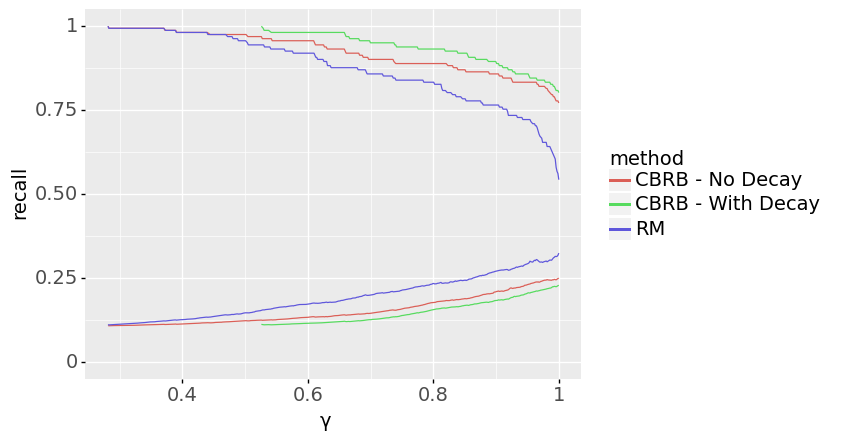

/tmp/ipykernel_10599/3681367896.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_10599/3681367896.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_10599/3681367896.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_10599/3681367896.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_10599/3681367896.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


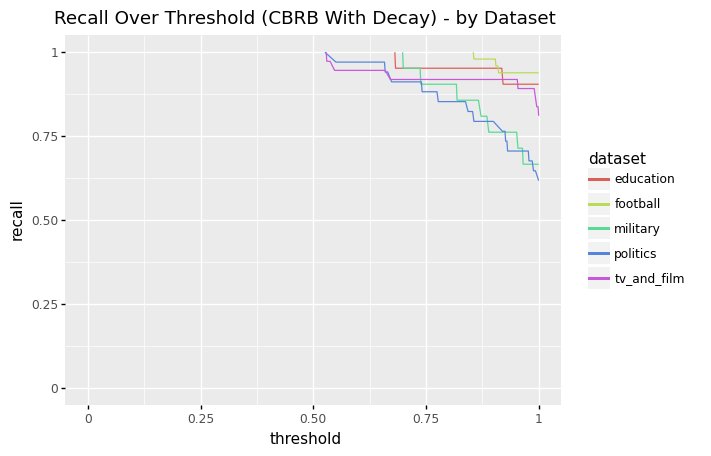

/tmp/ipykernel_10599/3681367896.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


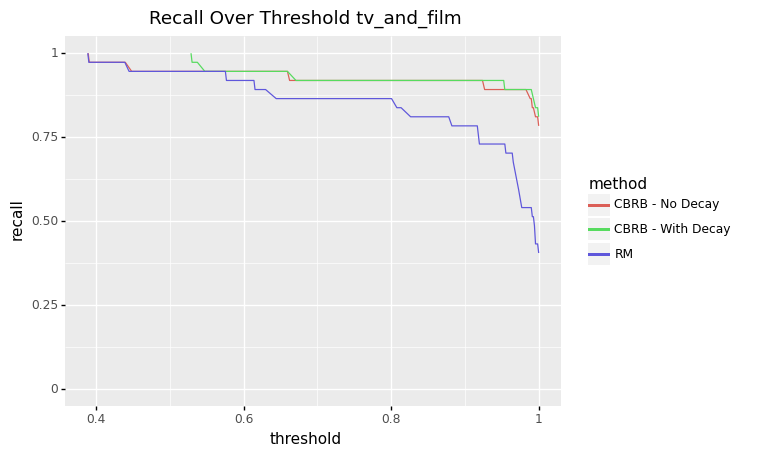

/tmp/ipykernel_10599/3681367896.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


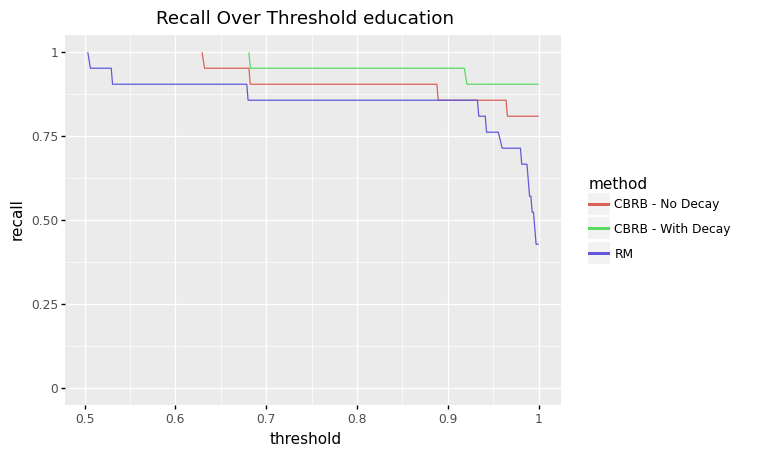

/tmp/ipykernel_10599/3681367896.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


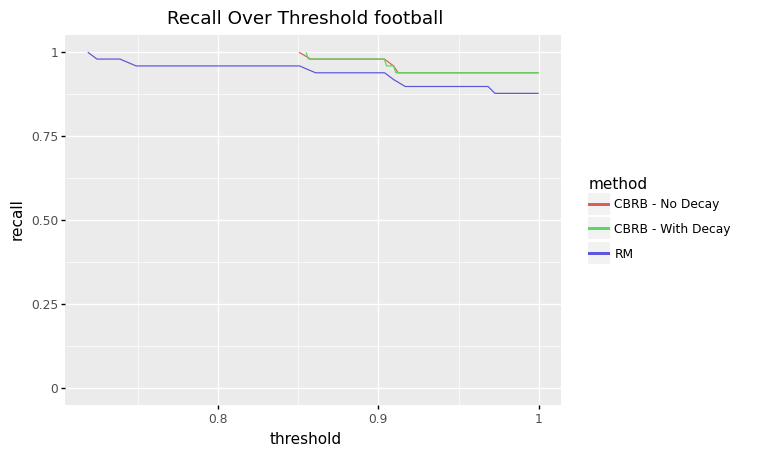

/tmp/ipykernel_10599/3681367896.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


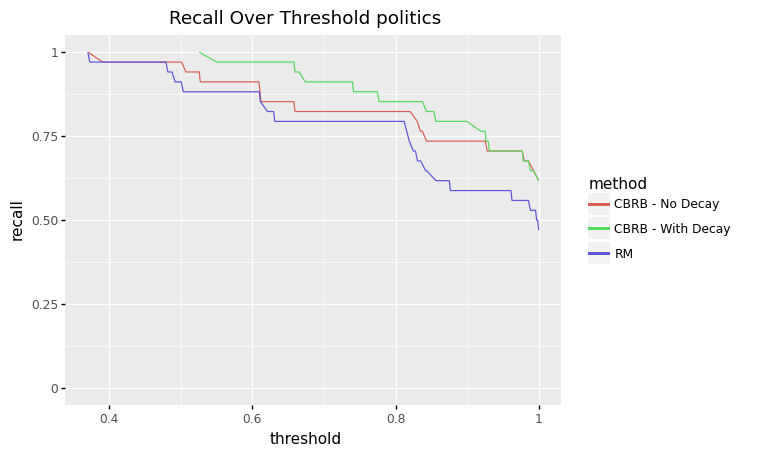

/tmp/ipykernel_10599/3681367896.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


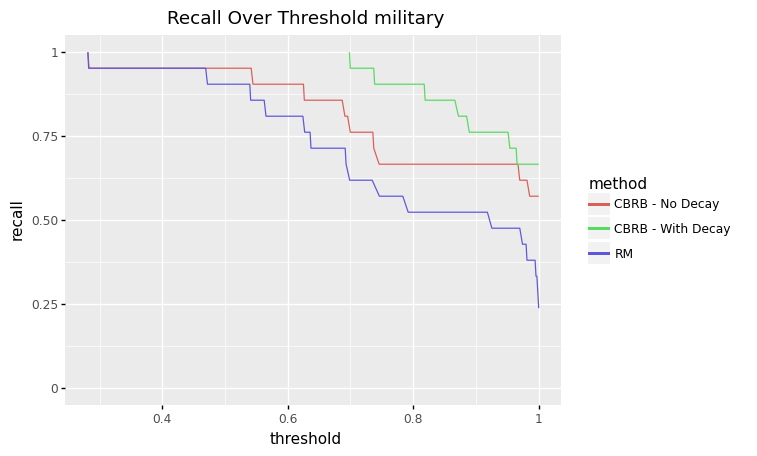

In [255]:
#exact match:
precision,recall,threshold = precision_recall_curve(df['isSemanticRoleMatch'],df['exactSequenceMatchPercentage'])
lowestThreshold = threshold[0]
relaxedMatchRecallDf = df[df['exactSequenceMatchPercentage']<lowestThreshold]
print("No Single true role match for below (with decay) ",lowestThreshold,"found in ",len(relaxedMatchRecallDf.index),"elements")
plotDFRelaxedExactMatch = pd.DataFrame({'recall': recall[0:len(recall)-1], 'threshold':threshold,"method":"RM", 'precision':precision[0:len(precision)-1]})

#no decay:
precision,recall,threshold = precision_recall_curve(df['isSemanticRoleMatch'],df['compatibilityPercentageDecay'])
lowestThreshold = threshold[0]
noRecallDf = df[df['compatibilityPercentageDecay']<lowestThreshold]
print("No Single true role match for below (with decay) ",lowestThreshold,"found in ",len(noRecallDf.index),"elements")
plotDF = pd.DataFrame({'recall': recall[0:len(recall)-1], 'threshold':threshold,"method":"CBRB - With Decay", 'precision':precision[0:len(precision)-1]})
#decay:
precision,recall,threshold = precision_recall_curve(df['isSemanticRoleMatch'],df['compatibilityPercentageNoDecay'])
lowestThreshold = threshold[0]
noRecallDf = df[df['compatibilityPercentageNoDecay']<lowestThreshold]
print("No Single true role match for below (without decay) ",lowestThreshold,"found in ",len(noRecallDf.index),"elements")
plotDF2 = pd.DataFrame({'recall': recall[0:len(recall)-1], 'threshold':threshold,"method":"CBRB - No Decay", 'precision':precision[0:len(precision)-1]})
finalPlotDF = plotDF.append(plotDF2).append(plotDFRelaxedExactMatch)
plot = ggplot(finalPlotDF,aes(x = 'threshold',y='recall',color="method",group="method")) + geom_line() + ylim(0, 1) + xlab("γ") + theme(text=element_text(size=14)) + geom_line(finalPlotDF,aes(x = 'threshold',y='precision',group="method",color="method"))#+ ggtitle("Recall on GOld Standard - all Datasets Combined")
print(plot)
#for every dataset:

finalDF = pd.DataFrame()
for ds in df.dataset.unique():
    thisDF = df[df['dataset']==ds]
    precision,recall,threshold = precision_recall_curve(thisDF['isSemanticRoleMatch'],thisDF['compatibilityPercentageDecay'])
    plotDF = pd.DataFrame({'recall': recall[0:len(recall)-1], 'threshold':threshold,'dataset':ds, 'precision':precision[0:len(precision)-1]})
    finalDF = finalDF.append(plotDF)
plot = ggplot(finalDF,aes(x = 'threshold',y='recall',group="dataset",color="dataset")) + geom_line() + xlim(0, 1) + ylim(0, 1) + ggtitle("Recall Over Threshold (CBRB With Decay) - by Dataset")
print(plot)

# For every dataset:
for ds in df.dataset.unique():
    thisDF = df[df['dataset']==ds]
    #exactMatch:
    precision,recall,threshold = precision_recall_curve(thisDF['isSemanticRoleMatch'],thisDF['exactSequenceMatchPercentage'])
    plotDFRelaxedExactMatch = pd.DataFrame({'recall': recall[0:len(recall)-1], 'threshold':threshold,"method":"RM"})
    #decay:
    precision,recall,threshold = precision_recall_curve(thisDF['isSemanticRoleMatch'],thisDF['compatibilityPercentageDecay'])
    plotDF = pd.DataFrame({'recall': recall[0:len(recall)-1], 'threshold':threshold,"method":"CBRB - With Decay"})
    #no decay:
    precision,recall,threshold = precision_recall_curve(thisDF['isSemanticRoleMatch'],thisDF['compatibilityPercentageNoDecay'])
    plotDF2 = pd.DataFrame({'recall': recall[0:len(recall)-1], 'threshold':threshold,"method":"CBRB - No Decay"})
    finalPlotDF = plotDF.append(plotDF2).append(plotDFRelaxedExactMatch)
    plot = ggplot(finalPlotDF,aes(x = 'threshold',y='recall',color="method",group="method")) + geom_line() + ylim(0, 1) + ggtitle("Recall Over Threshold " + ds)
    print(plot)



# Beta-Gamma Tradeoff

In [257]:
dfBetaGamma = pd.read_csv("localData/semanticAnnotation/gamma_beta_relationship.csv")
#dfBetaGamma = pd.read_csv("localData/semanticAnnotation/gamma_beta_relationship_laterTrainTimeEnd.csv")
print(dfBetaGamma.columns)
print(dfBetaGamma.dtypes)



# for ds in dfBetaGamma['dataset'].unique():
#     dsForThisDS = dfBetaGamma[dfBetaGamma['dataset']==ds]
#     dsShort = datasetToAbbreviation[ds]
#     plot = ggplot(df,aes(x = 'gamma',y='beta',fill="dataset",group='dataset')) + geom_histogram(position=position_dodge()) + theme(axis_text_x = element_text(angle=90, hjust=1))


Index(['dataset', 'id1', 'id2', 'betaThreshold', 'gammaThreshold', 'isInCBRB',
       'isSemanticRoleMatch'],
      dtype='object')
dataset                 object
id1                     object
id2                     object
betaThreshold          float64
gammaThreshold         float64
isInCBRB                  bool
isSemanticRoleMatch       bool
dtype: object


In [258]:
def getPRF(scoreName,group):
    tp = sum(((group[scoreName]) & (group['isSemanticRoleMatch'])))
    fp = sum(((group[scoreName]) & (~group['isSemanticRoleMatch'])))
    #tn = sum(((~group['isInCBRB']) & (~group['isSemanticRoleMatch'])))
    fn = sum((~group[scoreName] & group['isSemanticRoleMatch']))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    return precision,recall,f1


rows = []
grouped = dfBetaGamma.groupby(['dataset', 'betaThreshold', 'gammaThreshold'])
for (dataset,betaThreshold,gammaThreshold),group in grouped:
    precision,recall,f1 = getPRF("isInCBRB",group)
    rows.append({"dataset":dataset, "betaThreshold":betaThreshold, "gammaThreshold":gammaThreshold, "precision":precision, "recall":recall, "f1":f1})
finalDF = pd.DataFrame(rows)

rowsWithoutDatasetInGrouping = []
groupedWithoutDataset = dfBetaGamma.groupby(['betaThreshold','gammaThreshold'])
for (betaThreshold,gammaThreshold),group in groupedWithoutDataset:
    precision,recall,f1 = getPRF("isInCBRB",group)
    rowsWithoutDatasetInGrouping.append({"betaThreshold":betaThreshold, "gammaThreshold":gammaThreshold, "precision":precision, "recall":recall, "f1":f1})
finalDFWithoutDatasetInGrouping = pd.DataFrame(rowsWithoutDatasetInGrouping)


# For FCBRB

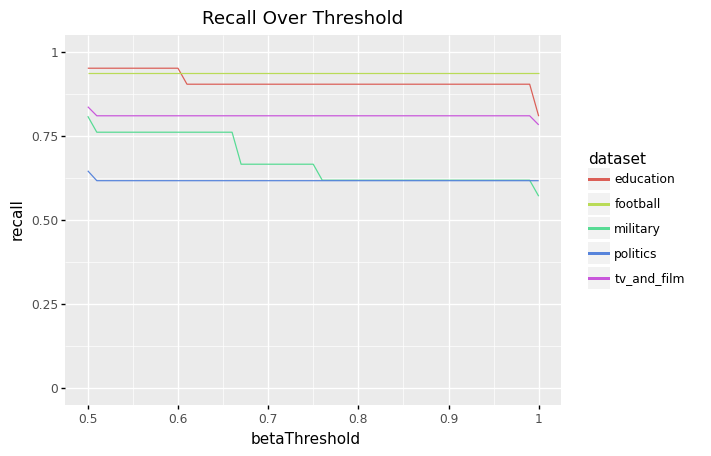

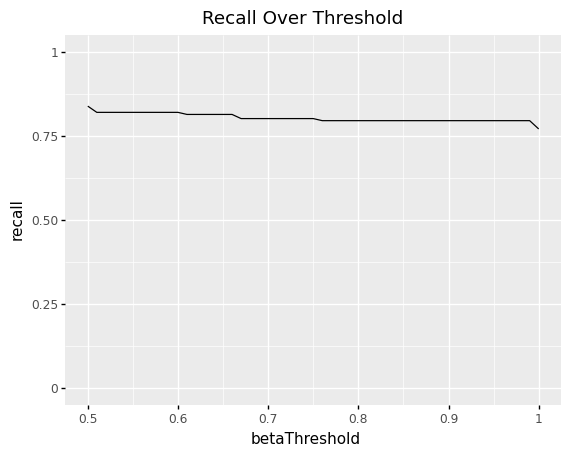

In [259]:
finalDFNoRelaxation = finalDF[finalDF['gammaThreshold']==1.0]
#By Dataset:
plot = ggplot(finalDFNoRelaxation,aes(x = 'betaThreshold',y='recall',color="dataset",group="dataset")) + geom_line() + ylim(0, 1) + ggtitle("Recall Over Threshold ")
print(plot)
#All:
finalDFNoRelaxationAll = finalDFWithoutDatasetInGrouping[finalDFWithoutDatasetInGrouping['gammaThreshold']==1.0]
plot = ggplot(finalDFNoRelaxationAll,aes(x = 'betaThreshold',y='recall')) + geom_line() + ylim(0, 1) + ggtitle("Recall Over Threshold ")
print(plot)

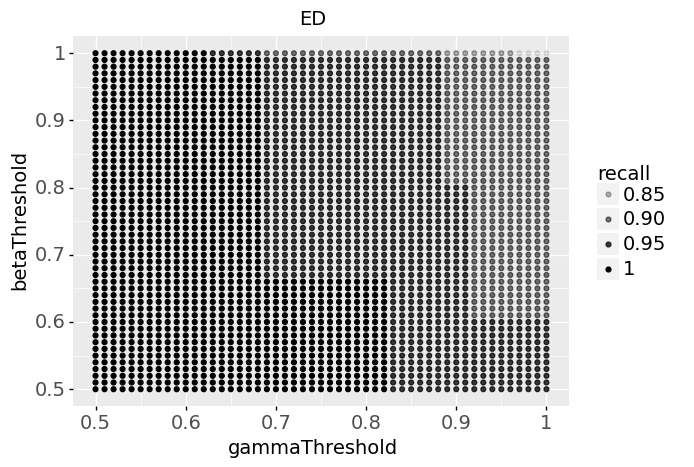

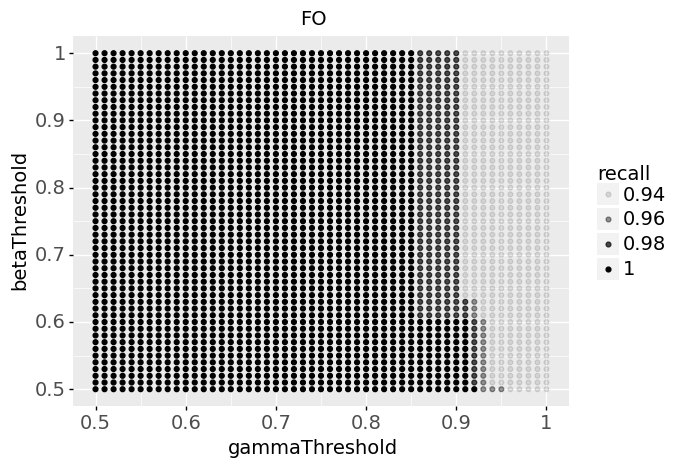

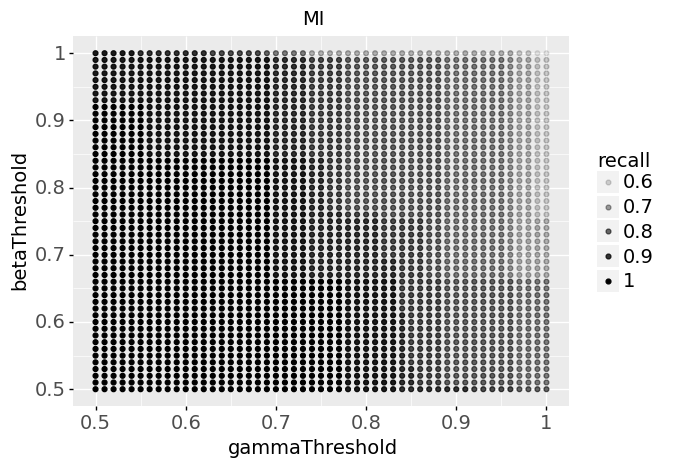

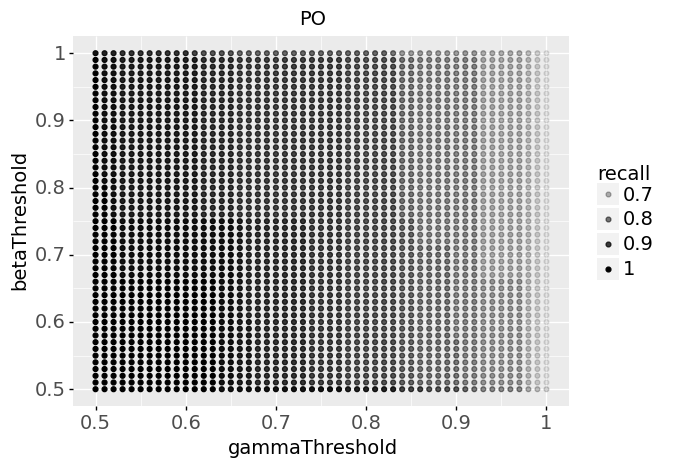

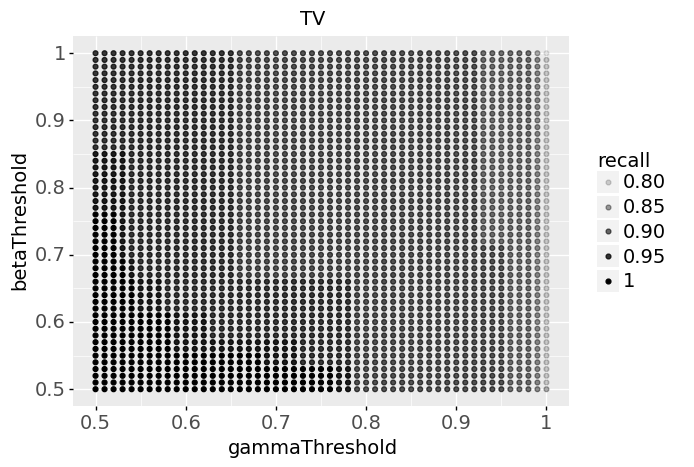

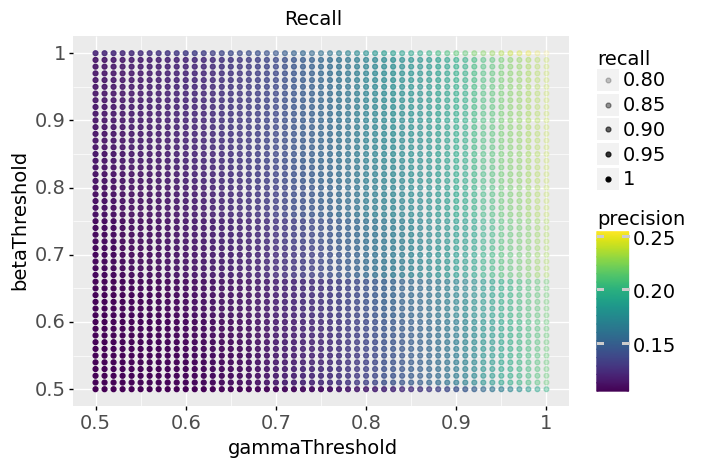

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/gammaBetaImpact_Recall.png


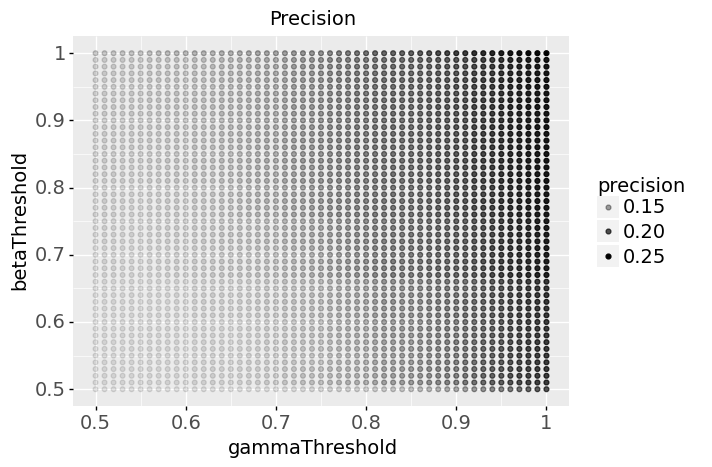

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/gammaBetaImpact_Precision.png


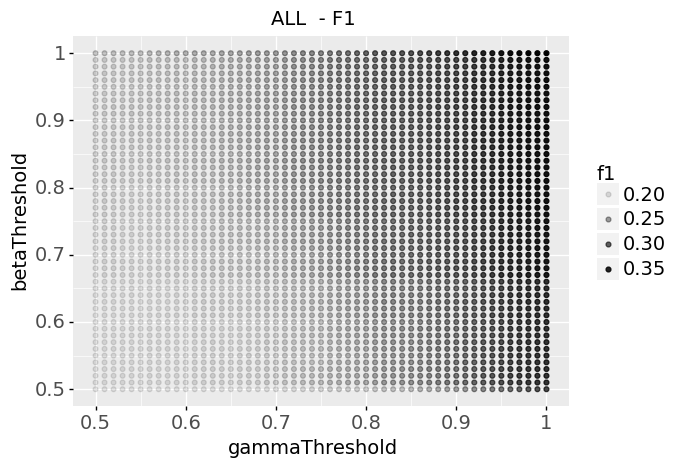

In [267]:

for ds in finalDF['dataset'].unique():
    dsForThisDS = finalDF[finalDF['dataset']==ds]
    dsShort = datasetToAbbreviation[ds]
    plot = ggplot(dsForThisDS,aes(x = 'gammaThreshold',y='betaThreshold',alpha="recall")) + geom_point() + xlim(0.5,1) + ylim(0.5,1) + ggtitle(dsShort) + theme(text=element_text(size=14))#+ theme(axis_text_x = element_text(angle=90, hjust=1))
    print(plot)
#for all
plot = ggplot(finalDFWithoutDatasetInGrouping,aes(x = 'gammaThreshold',y='betaThreshold',alpha="recall",color='precision')) + geom_point() + xlim(0.5,1) + ylim(0.5,1) + ggtitle("Recall")+ theme(text=element_text(size=14)) #+ theme(axis_text_x = element_text(angle=90, hjust=1))
print(plot)
plot.save("exportedPlots/gammaBetaImpact_Recall.png")
plot = ggplot(finalDFWithoutDatasetInGrouping,aes(x = 'gammaThreshold',y='betaThreshold',alpha="precision")) + geom_point() + xlim(0.5,1) + ylim(0.5,1) + ggtitle("Precision")+ theme(text=element_text(size=14))#+ theme(axis_text_x = element_text(angle=90, hjust=1))
print(plot)
plot.save("exportedPlots/gammaBetaImpact_Precision.png")
plot = ggplot(finalDFWithoutDatasetInGrouping,aes(x = 'gammaThreshold',y='betaThreshold',alpha="f1")) + geom_point() + xlim(0.5,1) + ylim(0.5,1) + ggtitle("ALL  - F1") + theme(text=element_text(size=14))#+ theme(axis_text_x = element_text(angle=90, hjust=1))
print(plot)

# Decay Curve for 0.8

      betaThreshold  gammaThreshold  precision    recall        f1
30             0.50             0.8   0.119540  0.962963  0.212679
81             0.51             0.8   0.136121  0.944444  0.237947
132            0.52             0.8   0.136121  0.944444  0.237947
183            0.53             0.8   0.136121  0.944444  0.237947
234            0.54             0.8   0.136242  0.944444  0.238132
285            0.55             0.8   0.136485  0.944444  0.238504
336            0.56             0.8   0.137343  0.944444  0.239812
387            0.57             0.8   0.137343  0.944444  0.239812
438            0.58             0.8   0.138713  0.944444  0.241897
489            0.59             0.8   0.139091  0.944444  0.242472
540            0.60             0.8   0.139091  0.944444  0.242472
591            0.61             0.8   0.142458  0.944444  0.247573
642            0.62             0.8   0.142591  0.944444  0.247773
693            0.63             0.8   0.143393  0.944444  0.24

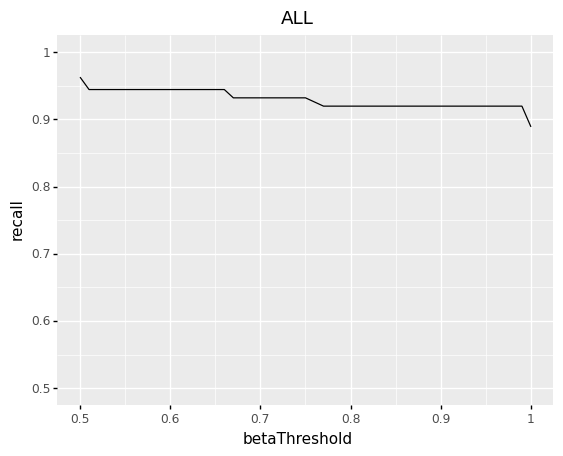

In [232]:
#All:

decayCurveDF = finalDFWithoutDatasetInGrouping[finalDFWithoutDatasetInGrouping['gammaThreshold']==0.8]
pd.set_option('display.max_rows', 500)
print(decayCurveDF)
pd.reset_option('display.max_rows')
plot = ggplot(decayCurveDF,aes(x = 'betaThreshold',y='recall')) + geom_line() + xlim(0.5,1) + ylim(0.5,1) + ggtitle("ALL")#+ theme(axis_text_x = element_text(angle=90, hjust=1))
print(plot)

# Target Recall - All

[1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9, 0.89, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8, 0.79, 0.78, 0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7, 0.69, 0.68, 0.67, 0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6, 0.59, 0.58, 0.57, 0.56, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5, 0.49, 0.48, 0.47, 0.46, 0.45, 0.44, 0.43, 0.42, 0.41, 0.4, 0.39, 0.38, 0.37, 0.36, 0.35, 0.34, 0.33, 0.32, 0.31, 0.3, 0.29, 0.28, 0.27, 0.26, 0.25, 0.24, 0.23, 0.22, 0.21, 0.2, 0.19, 0.18, 0.17, 0.16, 0.15, 0.14, 0.13, 0.12, 0.11, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]


/tmp/ipykernel_10599/533134889.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_10599/533134889.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_10599/533134889.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_10599/533134889.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

    recall  gammaCBRB (D)  betaCBRB (D)  gamma CBRB (ND)  gamma RM
0     1.00           0.51          0.76         0.281609  0.281205
1     0.99           0.76          0.50         0.370690  0.370158
2     0.98           0.65          0.75         0.439655  0.439024
3     0.97           0.76          0.53         0.501437  0.469154
4     0.96           0.77          0.64         0.541667  0.487805
5     0.95           0.78          0.64         0.610632  0.503587
6     0.94           0.82          0.66         0.625000  0.529412
7     0.93           0.83          0.67         0.658046  0.562410
8     0.92           0.81          0.76         0.659483  0.575323
9     0.91           0.83          0.96         0.686782  0.611191
10    0.90           0.85          0.97         0.735632  0.624103
11    0.89           0.88          0.96         0.737069  0.629842
12    0.88           0.90          0.96         0.830460  0.635581
13    0.87           0.92          0.96         0.850575  0.69

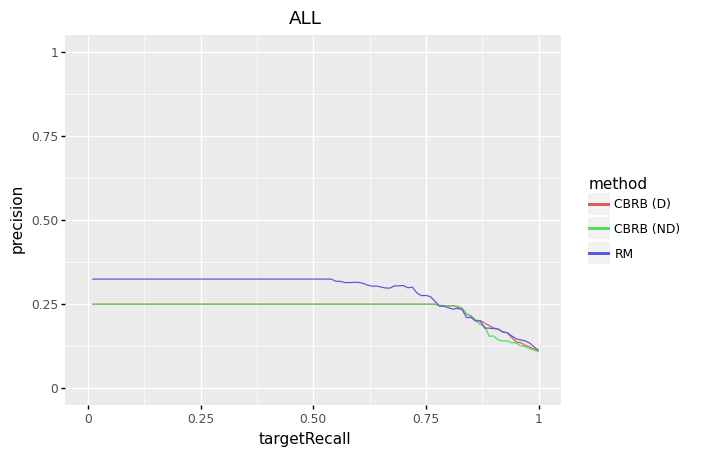

In [233]:
#All:
targetRecallThresholds = []
for i in range(0,100):
    targetRecallThresholds.append((100 - i)/100)
print(targetRecallThresholds)


def printBestPrecisionAtTargetRecall(dsName,finalDFWithoutDatasetInGrouping, targetRecall):
    filtered = finalDFWithoutDatasetInGrouping[finalDFWithoutDatasetInGrouping['recall']>=targetRecall]
    filtered.sort_values("precision",ascending=False,inplace=True)
    print(dsName)
    print(filtered.head(1))


def getPrecisionForTargetRecall(df, targetRecall):
    filtered = df[df['recall'] >= targetRecall]
    filtered.sort_values("precision",ascending=False,inplace=True)
    if(len(filtered.index)==0):
        return 0
    else:
        return filtered.iloc[0]['precision'],filtered.iloc[0]

def getPrecisionForTargetRecallForMethod(df, targetRecall, methodName):
    precision,recall,threshold = precision_recall_curve(df['isSemanticRoleMatch'], df[methodName])
    index = np.argmax(recall < targetRecall)-1
    return precision[index],threshold[index]

dsRows = []
configRows = []
for targetRecall in targetRecallThresholds:
    precisonCBRBWithDecay,precisionRowCBRB = getPrecisionForTargetRecall(finalDFWithoutDatasetInGrouping, targetRecall)
    dsRows.append({"method":"CBRB (D)","targetRecall":targetRecall,"precision":precisonCBRBWithDecay})
    precisionCBRBNoDecay,gammaThresholdCBRBNoDecay = getPrecisionForTargetRecallForMethod(df,targetRecall,"compatibilityPercentageNoDecay")
    dsRows.append({"method":"CBRB (ND)","targetRecall":targetRecall,"precision":precisionCBRBNoDecay})
    precisionRM,gammaThresholdRM = getPrecisionForTargetRecallForMethod(df,targetRecall,"exactSequenceMatchPercentage")
    dsRows.append({"method":"RM","targetRecall":targetRecall,"precision":precisionRM})
    configRows.append({"recall":targetRecall,
                       "gammaCBRB (D)":precisionRowCBRB['gammaThreshold'],
                       "betaCBRB (D)":precisionRowCBRB['betaThreshold'],
                       "gamma CBRB (ND)":gammaThresholdCBRBNoDecay,
                       "gamma RM":gammaThresholdRM})

configDF = pd.DataFrame(configRows)
pd.set_option('display.max_rows', 500)
print(configDF)

plotDF = pd.DataFrame(dsRows)

plot = ggplot(plotDF,aes(x = 'targetRecall',y='precision',group="method",color = "method")) + geom_line() + xlim(0,1) + ylim(0,1) + ggtitle("ALL")#+ theme(axis_text_x = element_text(angle=90, hjust=1))
print(plot)
# targetRecall=0.85

# printBestPrecisionAtTargetRecall("ALL",finalDFWithoutDatasetInGrouping,targetRecall)
#
# #For every Dataset:
# for ds in finalDF['dataset'].unique():
#     dsForThisDS = finalDF[finalDF['dataset']==ds]
#     printBestPrecisionAtTargetRecall(ds,dsForThisDS,targetRecall)
#
# best precision for RM:


# Target Recall - By Dataset

In [234]:
for ds in finalDF['dataset'].unique():
    dsForThisDS = finalDF[finalDF['dataset']==ds]
    dsShort = datasetToAbbreviation[ds]
    dsRows = []
    normalDfForThisDS = df[df['dataset']==ds]
    for targetRecall in targetRecallThresholds:
        precisonCBRBWithDecay = getPrecisionForTargetRecall(dsForThisDS, targetRecall)
        dsRows.append({"method":"CBRB (D)","targetRecall":targetRecall,"precision":precisonCBRBWithDecay})
        precisionCBRBNoDecay = getPrecisionForTargetRecallForMethod(normalDfForThisDS,targetRecall,"compatibilityPercentageNoDecay")
        dsRows.append({"method":"CBRB (ND)","targetRecall":targetRecall,"precision":precisionCBRBNoDecay})
        precisionRM = getPrecisionForTargetRecallForMethod(normalDfForThisDS,targetRecall,"exactSequenceMatchPercentage")
        dsRows.append({"method":"RM","targetRecall":targetRecall,"precision":precisionRM})
    plotDF = pd.DataFrame(dsRows)
    plot = ggplot(plotDF,aes(x = 'targetRecall',y='precision',group="method",color = "method")) + geom_line() + xlim(0,1) + ylim(0,1) + ggtitle(ds)#+ theme(axis_text_x = element_text(angle=90, hjust=1))
    print(plot)

/tmp/ipykernel_10599/533134889.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_10599/533134889.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_10599/533134889.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_10599/533134889.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

TypeError: Discrete value supplied to continuous scale

In [181]:

precision,recall,threshold = precision_recall_curve(df['isSemanticRoleMatch'],df['exactSequenceMatchPercentage'])
index = np.argmax(recall < targetRecall)-1
print(index)
print(threshold[index])
print(recall[index])
print(precision[index])

433
1.0
0.5432098765432098
0.3247232472324723
